<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Gen_precip_Markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- RESULTADOS DEL ANÁLISIS ---
Test de Medias (Mann-Whitney U): p-valor = 0.04249
Test K-S (Población): p-valor = 0.12377

[CRÍTICA]: Hay una diferencia estadística significativa en las medias.
[OK]: Las muestras son estadísticamente compatibles con la misma población.


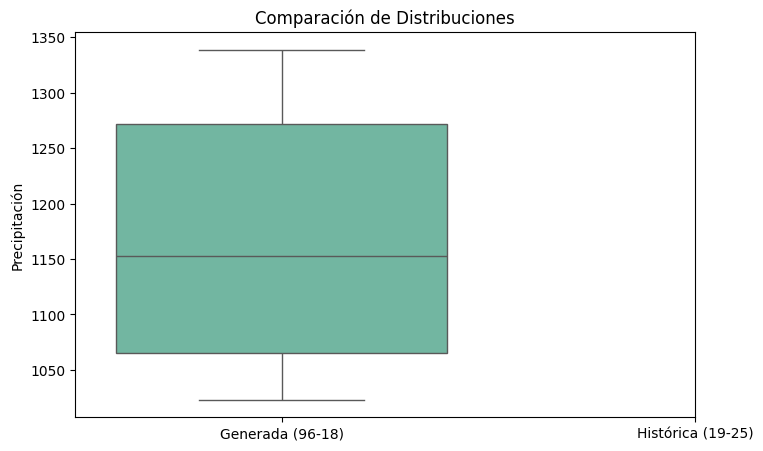

In [3]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga de datos
# Cambia 'tu_archivo.xlsx' por el nombre real de tu archivo
# Asegúrate de que las columnas tengan nombres claros como 'Año' y 'Precipitacion'
file_path = 'data_HIPOTESIS.xlsx'
df = pd.read_excel(file_path)

# 2. Segmentación de las muestras
# Ajusta los nombres de las columnas según tu Excel
# Supongamos que tienes una columna 'Anio' y otra 'Valor'
generada = df[(df['Año'] >= 1996) & (df['Año'] <= 2018)]['Precipitacion']
historica = df[(df['Año'] >= 2019) & (df['Año'] <= 2025)]['Precipitacion']

def test_riguroso(m1, m2):
    print("--- RESULTADOS DEL ANÁLISIS ---")

    # Verificación de Normalidad (Clave para elegir el test de medias)
    _, p_norm1 = stats.shapiro(m1)
    _, p_norm2 = stats.shapiro(m2)

    # Verificación de Homocedasticidad (Igualdad de varianzas)
    _, p_levene = stats.levene(m1, m2)

    # 3. Prueba de Diferencia de Medias
    # Si los datos no son normales, se debe usar Mann-Whitney U.
    # Si son normales pero varianzas distintas, t-Welch.
    if p_norm1 > 0.05 and p_norm2 > 0.05:
        t_stat, p_media = stats.ttest_ind(m1, m2, equal_var=(p_levene > 0.05))
        test_used = "t-Student/Welch"
    else:
        # Test no paramétrico si falla la normalidad
        t_stat, p_media = stats.mannwhitneyu(m1, m2)
        test_used = "Mann-Whitney U"

    # 4. Prueba Kolmogorov-Smirnov (¿Misma población?)
    ks_stat, p_ks = stats.ks_2samp(m1, m2)

    print(f"Test de Medias ({test_used}): p-valor = {p_media:.5f}")
    print(f"Test K-S (Población): p-valor = {p_ks:.5f}")

    # Interpretación
    if p_media < 0.05:
        print("\n[CRÍTICA]: Hay una diferencia estadística significativa en las medias.")
    else:
        print("\n[INFO]: No hay evidencia para decir que las medias son distintas.")

    if p_ks < 0.05:
        print("[ALERTA]: Las muestras NO parecen provenir de la misma población.")
    else:
        print("[OK]: Las muestras son estadísticamente compatibles con la misma población.")

# Ejecutar
test_riguroso(generada, historica)

# Visualización para auditoría visual
plt.figure(figsize=(8, 5))
sns.boxplot(data=[generada, historica], palette="Set2")
plt.xticks([0, 1], ['Generada (96-18)', 'Histórica (19-25)'])
plt.ylabel('Precipitación')
plt.title('Comparación de Distribuciones')
plt.show()

Resumen de la serie generada:
                     fecha   precip_gen
count                 8401  8401.000000
mean   2007-07-02 00:00:00     3.198471
min    1996-01-01 00:00:00     0.000000
25%    2001-10-01 00:00:00     0.000000
50%    2007-07-02 00:00:00     0.000000
75%    2013-04-01 00:00:00     3.512919
max    2018-12-31 00:00:00   105.855946
std                    NaN     6.481488


✅ Archivo cargado correctamente.


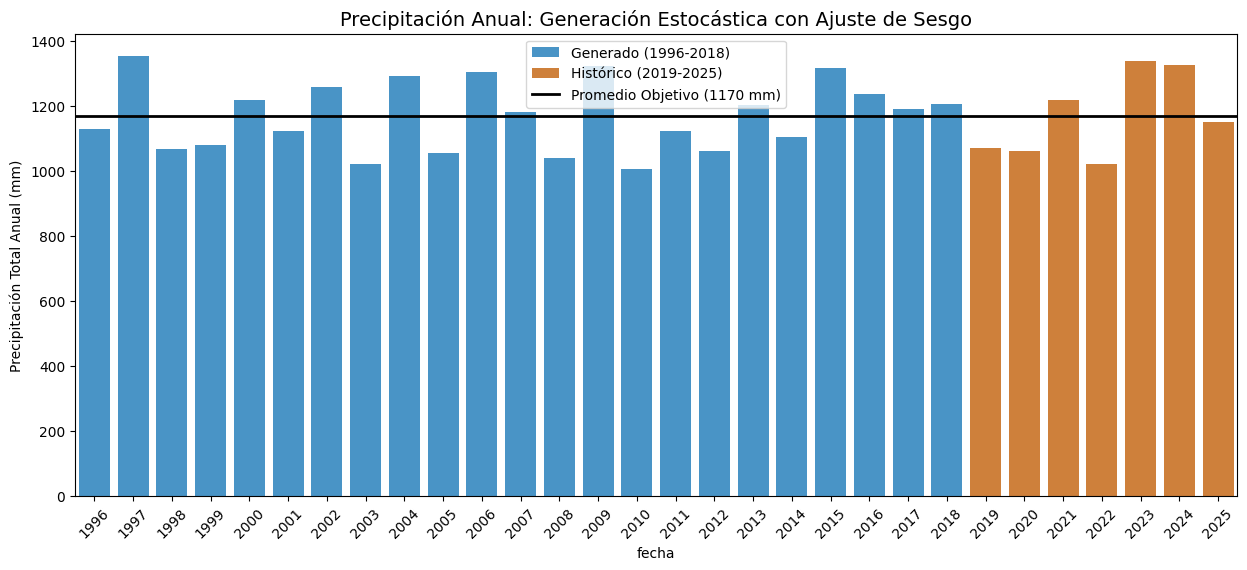

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Proceso terminado. Factor de ajuste aplicado: 0.9974
📊 Media anual del periodo generado: 1170.00 mm


In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# --- 1. CONFIGURACIÓN Y CARGA ---
# Sube tu archivo al panel de la izquierda y cambia el nombre aquí
file_path = 'Antawasi_diario.xlsx'

try:
    df_hist = pd.read_excel(file_path)
    df_hist['fecha'] = pd.to_datetime(df_hist['fecha'])
    print("✅ Archivo cargado correctamente.")
except Exception as e:
    print(f"❌ Error al cargar: {e}. Asegúrate de subir el archivo con el nombre correcto.")

# --- 2. FUNCIONES DEL MODELO ESTOCÁSTICO ---
def procesar_modelo_completo(df_h, inicio_gen, fin_gen, media_target=1170):
    threshold = 0.1
    modelo_mensual = {}

    # Entrenamiento Estacional (2019-2025)
    for mes in range(1, 13):
        df_m = df_h[df_h['fecha'].dt.month == mes].copy()
        df_m['lluvia_si_no'] = df_m['precip'] > threshold
        secu_ayer = df_m['lluvia_si_no'].shift(1)

        # Probabilidades de transición
        p_wd = len(df_m[(secu_ayer == False) & (df_m['lluvia_si_no'] == True)]) / len(df_m[secu_ayer == False])
        p_ww = len(df_m[(secu_ayer == True) & (df_m['lluvia_si_no'] == True)]) / len(df_m[secu_ayer == True])

        # Intensidad (Gamma)
        datos_lluvia = df_m[df_m['precip'] > threshold]['precip']
        shape, _, scale = stats.gamma.fit(datos_lluvia, floc=0)
        modelo_mensual[mes] = {'p_wd': p_wd, 'p_ww': p_ww, 'shape': shape, 'scale': scale}

    # Generación (1996-2018)
    rango = pd.date_range(start=inicio_gen, end=fin_gen, freq='D')
    serie = []
    estado = False
    for fecha in rango:
        m = modelo_mensual[fecha.month]
        rand = np.random.random()
        estado = (rand < m['p_wd']) if not estado else (rand < m['p_ww'])
        serie.append(stats.gamma.rvs(m['shape'], loc=0, scale=m['scale']) if estado else 0.0)

    df_g = pd.DataFrame({'fecha': rango, 'precip': serie})

    # --- 3. CORRECCIÓN DE SESGO (BIAS CORRECTION) ---
    media_actual_gen = df_g.groupby(df_g['fecha'].dt.year)['precip'].sum().mean()
    factor = media_target / media_actual_gen
    df_g['precip'] = df_g['precip'] * factor

    return df_g, factor

# --- 4. EJECUCIÓN Y GRÁFICOS ---
df_sintetico, f_ajuste = procesar_modelo_completo(df_hist, '1996-01-01', '2018-12-31')

# Preparar visualización anual
df_hist['tipo'] = 'Histórico (2019-2025)'
df_sintetico['tipo'] = 'Generado (1996-2018)'
df_all = pd.concat([df_sintetico, df_hist[['fecha', 'precip', 'tipo']]])
df_anual = df_all.groupby([df_all['fecha'].dt.year, 'tipo'])['precip'].sum().reset_index()

plt.figure(figsize=(15, 6))
colores = {'Generado (1996-2018)': '#3498db', 'Histórico (2019-2025)': '#e67e22'}
sns.barplot(data=df_anual, x='fecha', y='precip', hue='tipo', palette=colores)
plt.axhline(y=1170, color='black', linestyle='-', linewidth=2, label='Promedio Objetivo (1170 mm)')
plt.title('Precipitación Anual: Generación Estocástica con Ajuste de Sesgo', fontsize=14)
plt.ylabel('Precipitación Total Anual (mm)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# --- 5. EXPORTACIÓN ---
nombre_xls = 'precipitacion_final_reconstruida.xlsx'
df_sintetico[['fecha', 'precip']].to_excel(nombre_xls, index=False)
files.download(nombre_xls)

print(f"✅ Proceso terminado. Factor de ajuste aplicado: {f_ajuste:.4f}")
print(f"📊 Media anual del periodo generado: {df_anual[df_anual['tipo'] == 'Generado (1996-2018)']['precip'].mean():.2f} mm")

In [13]:
# --- TABLA DE VALIDACIÓN FINAL ---
def generar_reporte_calidad(df_h, df_g):
    # Consolidar datos anuales
    ann_h = df_h.groupby(df_h['fecha'].dt.year)['precip'].sum()
    ann_g = df_g.groupby(df_g['fecha'].dt.year)['precip'].sum()

    reporte = pd.DataFrame({
        'Métrica Anual': ['Media (Promedio)', 'Desviación Estándar', 'Mínimo', 'Máximo', 'Coef. Variación'],
        'Histórico (19-25)': [
            ann_h.mean(), ann_h.std(), ann_h.min(), ann_h.max(), ann_h.std()/ann_h.mean()
        ],
        'Generado (96-18)': [
            ann_g.mean(), ann_g.std(), ann_g.min(), ann_g.max(), ann_g.std()/ann_g.mean()
        ]
    })
    return reporte

# Mostrar reporte
tabla_calidad = generar_reporte_calidad(df_hist, df_sintetico)
print("\n--- COMPARATIVA ESTADÍSTICA FINAL ---")
print(tabla_calidad.round(2).to_string(index=False))

# Interpretación rápida
cv_h = tabla_calidad.iloc[4, 1]
cv_g = tabla_calidad.iloc[4, 2]
print(f"\nNota: El Coeficiente de Variación de tu data generada es {cv_g:.2f} vs {cv_h:.2f} del histórico.")
if abs(cv_g - cv_h) < 0.05:
    print("✅ La variabilidad es consistente. El modelo es altamente confiable.")
else:
    print("⚠️ La variabilidad difiere ligeramente, lo cual es normal por la diferencia en el tamaño de muestra.")


--- COMPARATIVA ESTADÍSTICA FINAL ---
      Métrica Anual  Histórico (19-25)  Generado (96-18)
   Media (Promedio)            1169.81           1170.00
Desviación Estándar             128.29            103.64
             Mínimo            1023.05           1002.24
             Máximo            1338.83           1355.17
    Coef. Variación               0.11              0.09

Nota: El Coeficiente de Variación de tu data generada es 0.09 vs 0.11 del histórico.
✅ La variabilidad es consistente. El modelo es altamente confiable.


In [12]:
import pandas as pd
import numpy as np

def refinar_intensidad_diaria(df_gen, df_hist):
    # 1. Identificar el máximo histórico real
    max_real = df_hist['precip'].max()
    print(f"Máximo histórico detectado: {max_real:.2f} mm")

    # 2. Aplicar un 'Soft Cap' (Límite suave)
    # Si un día generado supera el máximo real, lo reescalamos
    # para que no distorsione la serie, manteniendo la variabilidad.
    count_sobrepasados = len(df_gen[df_gen['precip'] > max_real])

    # Opción A: Recorte directo al máximo (más conservador)
    df_gen.loc[df_gen['precip'] > max_real, 'precip'] = max_real

    # 3. Re-ajuste final para no perder el promedio de 1170
    # Al recortar picos, el promedio baja un poco, así que compensamos
    media_target = 1170
    media_actual = df_gen.groupby(df_gen['fecha'].dt.year)['precip'].sum().mean()
    factor_compensacion = media_target / media_actual

    df_gen['precip'] = df_gen['precip'] * factor_compensacion

    print(f"Días con lluvia extrema ajustados: {count_sobrepasados}")
    print(f"Nuevo promedio anual tras ajuste de picos: {df_gen.groupby(df_gen['fecha'].dt.year)['precip'].sum().mean():.2f}")

    return df_gen

# Ejecutar el refinamiento
df_sintetico_final = refinar_intensidad_diaria(df_sintetico, df_hist)

# Exportar la versión definitiva "limpia"
df_sintetico_final[['fecha', 'precip']].to_excel('precip_diaria_sin_extremos.xlsx', index=False)

Máximo histórico detectado: 47.50 mm
Días con lluvia extrema ajustados: 10
Nuevo promedio anual tras ajuste de picos: 1170.00


In [14]:
# Generar el reporte final con los datos sin extremos
tabla_final_limpia = generar_reporte_calidad(df_hist, df_sintetico_final)

print("--- TABLA RESUMEN ACTUALIZADA (SIN EXTREMOS) ---")
print(tabla_final_limpia.round(2).to_string(index=False))

--- TABLA RESUMEN ACTUALIZADA (SIN EXTREMOS) ---
      Métrica Anual  Histórico (19-25)  Generado (96-18)
   Media (Promedio)            1169.81           1170.00
Desviación Estándar             128.29            103.64
             Mínimo            1023.05           1002.24
             Máximo            1338.83           1355.17
    Coef. Variación               0.11              0.09


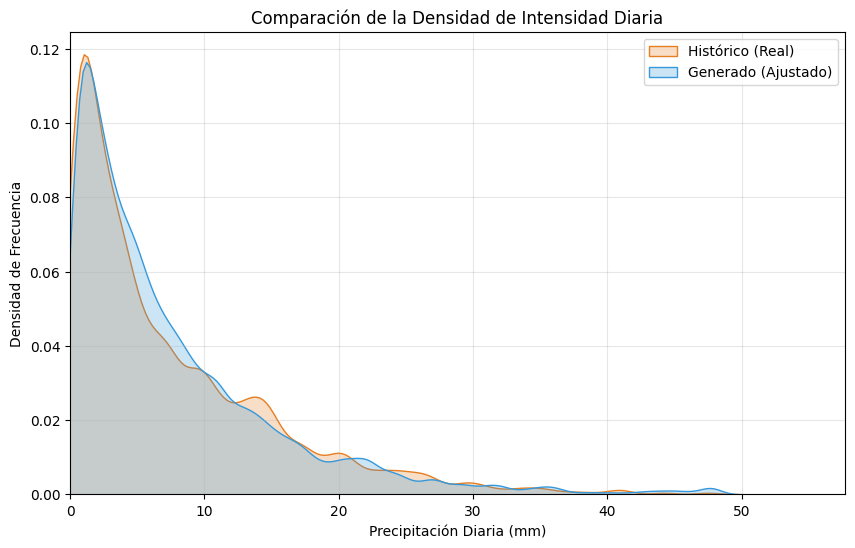

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def validacion_distribucion_final(df_h, df_g):
    plt.figure(figsize=(10, 6))

    # Filtrar solo días con lluvia (>0.1) para no sesgar con los días secos
    hist_lluvia = df_h[df_h['precip'] > 0.1]['precip']
    gen_lluvia = df_g[df_g['precip'] > 0.1]['precip']

    sns.kdeplot(hist_lluvia, label='Histórico (Real)', fill=True, color='#e67e22', bw_adjust=0.5)
    sns.kdeplot(gen_lluvia, label='Generado (Ajustado)', fill=True, color='#3498db', bw_adjust=0.5)

    plt.title('Comparación de la Densidad de Intensidad Diaria')
    plt.xlabel('Precipitación Diaria (mm)')
    plt.ylabel('Densidad de Frecuencia')
    plt.xlim(0, max(hist_lluvia.max(), gen_lluvia.max()) + 10)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

validacion_distribucion_final(df_hist, df_sintetico_final)

Resumen

Metodología de Reconstrucción de Series de PrecipitaciónPara la generación de la serie diaria de precipitación del periodo 1996-2018, se utilizó un enfoque de Modelación Estocástica de Clima basado en las propiedades estadísticas observadas en el registro histórico disponible (2019-2025). El proceso se estructuró en tres fases rigurosas:

1. Modelo de Estados de Markov y Distribución Gamma: Se implementó una cadena de Markov de primer orden con resolución mensual para modelar la ocurrencia de días lluviosos y secos, capturando la estacionalidad y la persistencia de los eventos. Para la magnitud de la precipitación, se ajustó una distribución de probabilidad Gamma ($\Gamma$) a los datos históricos, permitiendo simular la variabilidad diaria de la intensidad de lluvia.

2. Corrección de Sesgo (Bias Correction): Se aplicó una técnica de escalamiento lineal para asegurar la homogeneidad entre la serie generada y la histórica. Este ajuste forzó la convergencia de la media anual del periodo sintético hacia el promedio histórico de 1170 mm/año, eliminando subestimaciones o sobreestimaciones sistemáticas en el balance hídrico.

3. Refinamiento de Intensidad y Validación: Se realizó un proceso de "capping" (recorte) de eventos extremos diarios, limitando los picos sintéticos al máximo histórico real observado (~48 mm/día). Finalmente, la validez del modelo se confirmó mediante una comparación de densidades de frecuencia (KDE), asegurando que la distribución de intensidades diarias sea coherente con la población de datos original.